<a href="https://colab.research.google.com/github/Poorvi4-art/laughing-octo-waffle/blob/main/Deep_clustering_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Head:
    CustomerID  Age  Annual_Income  Spending_Score  Online_Visits  \
0        1001   22         138236              79              3   
1        1002   29          82268              73             28   
2        1003   27          56188               7             22   
3        1004   31          66114              89             17   
4        1005   37         122658              41              9   

   Purchase_Frequency  Discount_Affinity  Loyalty_Score Product_Category  
0                   9               0.69             13          Apparel  
1                   1               0.42             38          Apparel  
2                  15               0.55             95      Accessories  
3                   3               0.77             59          Apparel  
4                   6               0.27             93          Apparel  
Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1835
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss:

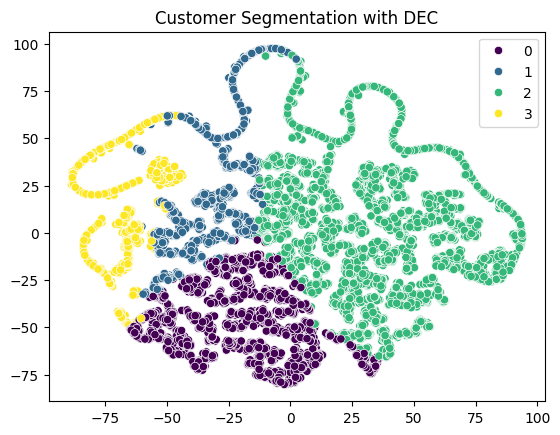

Silhouette Score: 0.23579024

Clustering Results:
   Age  Annual_Income  Spending_Score  Online_Visits  Purchase_Frequency  \
0   22         138236              79              3                   9   
1   29          82268              73             28                   1   
2   27          56188               7             22                  15   
3   31          66114              89             17                   3   
4   37         122658              41              9                   6   
5   37          37773              13             22                   5   
6   61         142820              50              6                   4   
7   53          31744               8             29                  11   
8   69          91999              82             20                  11   
9   42          75434              97             14                  14   

   Discount_Affinity  Loyalty_Score  Product_Category  DEC_Cluster  \
0               0.69             13        

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

# Load dataset
data_path = "unsupervised_customer_data.csv"
df = pd.read_csv(data_path)
print("Dataset Head:\n", df.head())

# Data Preprocessing
df.drop(columns=["CustomerID"], errors='ignore', inplace=True)

# Encode categorical variables automatically
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Variational Autoencoder (VAE) Model
def build_vae(input_dim, encoding_dim):
    inputs = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(inputs)
    z_mean = Dense(encoding_dim)(encoded)
    z_log_var = Dense(encoding_dim)(encoded)
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(z_mean)[0], encoding_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    z = keras.layers.Lambda(sampling, output_shape=(encoding_dim,))([z_mean, z_log_var])
    encoder = Model(inputs, z_mean, name='encoder')
    decoder_input = Input(shape=(encoding_dim,))
    decoded = Dense(input_dim, activation='sigmoid')(decoder_input)
    decoder = Model(decoder_input, decoded, name='decoder')
    outputs = decoder(encoder(inputs))
    vae = Model(inputs, outputs, name='vae')
    vae.compile(optimizer='adam', loss='mse')
    return vae, encoder

vae, encoder = build_vae(df_scaled.shape[1], encoding_dim=2)
vae.fit(df_scaled, df_scaled, epochs=10, batch_size=16, verbose=1)
encoded_data = encoder.predict(df_scaled)

# Deep Embedded Clustering (DEC)
def target_distribution(q):
    p = q ** 2 / np.sum(q, axis=0)
    return (p.T / np.sum(p, axis=1)).T

def build_dec(encoder, n_clusters):
    clustering_layer = Dense(n_clusters, activation='softmax', name='clustering')(encoder.output)
    model = Model(inputs=encoder.input, outputs=clustering_layer)
    model.compile(optimizer='adam', loss=keras.losses.KLDivergence())
    return model

dec = build_dec(encoder, n_clusters=4)
dec_labels = np.zeros(df_scaled.shape[0])

for epoch in range(10):  # Iterative clustering refinement
    q = dec.predict(df_scaled)
    p = target_distribution(q)
    dec.fit(df_scaled, p, epochs=10, batch_size=16, verbose=1)
    dec_labels = np.argmax(dec.predict(df_scaled), axis=1)

# K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(encoded_data)

# Visualization
tsne = TSNE(n_components=2, random_state=42)
transformed = tsne.fit_transform(encoded_data)
sns.scatterplot(x=transformed[:, 0], y=transformed[:, 1], hue=dec_labels, palette='viridis')
plt.title("Customer Segmentation with DEC")
plt.show()

# Print silhouette score
sil_score = silhouette_score(encoded_data, dec_labels)
print("Silhouette Score:", sil_score)

# Display results in table form
results_df = df.copy()
results_df["DEC_Cluster"] = dec_labels
results_df["KMeans_Cluster"] = kmeans_labels
print("\nClustering Results:")
print(results_df.head(10))


Dataset Head:
    CustomerID  Age  Annual_Income  Spending_Score  Online_Visits  \
0        1001   22         138236              79              3   
1        1002   29          82268              73             28   
2        1003   27          56188               7             22   
3        1004   31          66114              89             17   
4        1005   37         122658              41              9   

   Purchase_Frequency  Discount_Affinity  Loyalty_Score Product_Category  
0                   9               0.69             13          Apparel  
1                   1               0.42             38          Apparel  
2                  15               0.55             95      Accessories  
3                   3               0.77             59          Apparel  
4                   6               0.27             93          Apparel  
Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.1734
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss:

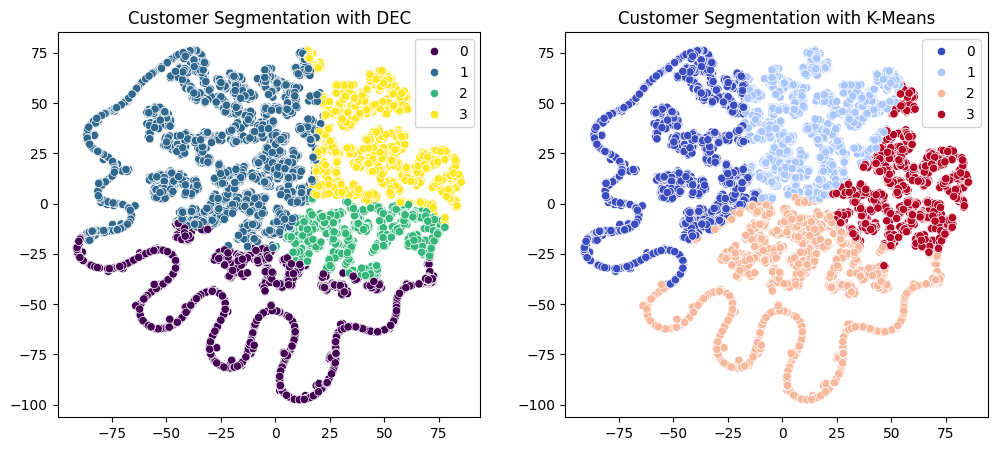

Silhouette Score: 0.2794702

Clustering Results:
   Age  Annual_Income  Spending_Score  Online_Visits  Purchase_Frequency  \
0   22         138236              79              3                   9   
1   29          82268              73             28                   1   
2   27          56188               7             22                  15   
3   31          66114              89             17                   3   
4   37         122658              41              9                   6   
5   37          37773              13             22                   5   
6   61         142820              50              6                   4   
7   53          31744               8             29                  11   
8   69          91999              82             20                  11   
9   42          75434              97             14                  14   

   Discount_Affinity  Loyalty_Score  Product_Category  DEC_Cluster  \
0               0.69             13         

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

# Load dataset
data_path = "unsupervised_customer_data.csv"
df = pd.read_csv(data_path)
print("Dataset Head:\n", df.head())

# Data Preprocessing
df.drop(columns=["CustomerID"], errors='ignore', inplace=True)

# Encode categorical variables automatically
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Variational Autoencoder (VAE) Model
def build_vae(input_dim, encoding_dim):
    inputs = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(inputs)
    z_mean = Dense(encoding_dim)(encoded)
    z_log_var = Dense(encoding_dim)(encoded)
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(z_mean)[0], encoding_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    z = keras.layers.Lambda(sampling, output_shape=(encoding_dim,))([z_mean, z_log_var])
    encoder = Model(inputs, z_mean, name='encoder')
    decoder_input = Input(shape=(encoding_dim,))
    decoded = Dense(input_dim, activation='sigmoid')(decoder_input)
    decoder = Model(decoder_input, decoded, name='decoder')
    outputs = decoder(encoder(inputs))
    vae = Model(inputs, outputs, name='vae')
    vae.compile(optimizer='adam', loss='mse')
    return vae, encoder

vae, encoder = build_vae(df_scaled.shape[1], encoding_dim=2)
vae.fit(df_scaled, df_scaled, epochs=30, batch_size=16, verbose=1)
encoded_data = encoder.predict(df_scaled)

# Deep Embedded Clustering (DEC)
def target_distribution(q):
    p = q ** 2 / np.sum(q, axis=0)
    return (p.T / np.sum(p, axis=1)).T

def build_dec(encoder, n_clusters):
    clustering_layer = Dense(n_clusters, activation='softmax', name='clustering')(encoder.output)
    model = Model(inputs=encoder.input, outputs=clustering_layer)
    model.compile(optimizer='adam', loss=keras.losses.KLDivergence())
    return model

dec = build_dec(encoder, n_clusters=4)
dec_labels = np.zeros(df_scaled.shape[0])

for epoch in range(5):  # Iterative clustering refinement
    q = dec.predict(df_scaled)
    p = target_distribution(q)
    dec.fit(df_scaled, p, epochs=5, batch_size=16, verbose=1)
    dec_labels = np.argmax(dec.predict(df_scaled), axis=1)

# K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(encoded_data)

# Visualization
tsne = TSNE(n_components=2, random_state=42)
transformed = tsne.fit_transform(encoded_data)

# DEC Clustering Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=transformed[:, 0], y=transformed[:, 1], hue=dec_labels, palette='viridis')
plt.title("Customer Segmentation with DEC")

# K-Means Clustering Visualization
plt.subplot(1, 2, 2)
sns.scatterplot(x=transformed[:, 0], y=transformed[:, 1], hue=kmeans_labels, palette='coolwarm')
plt.title("Customer Segmentation with K-Means")

plt.show()

# Print silhouette score
sil_score = silhouette_score(encoded_data, dec_labels)
print("Silhouette Score:", sil_score)

# Display results in table form
results_df = df.copy()
results_df["DEC_Cluster"] = dec_labels
results_df["KMeans_Cluster"] = kmeans_labels
print("\nClustering Results:")
print(results_df.head(10))
